# Chapter 14. CNN

- The architecture of the visual cortex
    - local receptive field
    - some neurons responding to specific pattern
    - some neurons react with larger receptive fields react to more complex patterns

- Yann LeCun and LeNet-5 (1998)
    - innovations: **convolutional layers** and **pooling layers**

- Why not deep neural network? 
    - only work for small input data
    - num of parameters are too huge

- advantages of CNNs 
    - **partially connected layers**
    - **weight sharing** (??? check Andrew Ng's lecture)

## setup

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print('setup complete.')

No GPU was detected. CNNs can be very slow without a GPU.
setup complete.


In [8]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Convolutional Layers

- neurons in the previous layer are not fully connected to every neuron in the next layer

- each neuron in a later layer is only connected to a **limited field** of neurons in the previous layer

- this architecture allows the **identification** of **lower-level features** via the **earlier layers** and the **assembly** of **higher-level features** in **later layers**

- **zero padding** : one ring of **zero values** added around the **boundary** of input data so that the output of convolution is in the **same shape**. 

- **stride** : spacing between each receptive field, which could reduce the size of the output. 

## Filters

- A **filter**, or **convolution kernel**, represents the **weights** applied to the receptive field cropped out from input data during each step of scan

- the **weights** in the filter indicate **the extent to which each piece of info in the receptive field will be retained, or ignored**. 

- each **filter** produces one **feature map**, which highlights the info in input data that **activates**, or **match**, the pattern of the filter the most. 

- each **pixel** in a feature map is one **neuron**. 

- all neurons, or "pixels", in a feature map **share the _same_ set of weights**, as opposed to common DNN, in which all neurons in one layer have totally different **sets of weights**.  

- each feature map is associated with one unique set of weights (filter) 

- a **convolution process** applies simultaniously multiple **filters**, or multiple **sets of weights**, to inputs, making it capable of detecting multiple **features**. 

- the training of a CNN is the process of **learning** automatically these **filters, or sets of weights** for the task as defined

- higher layers will learn the **combined features** for more **complex patterns**. 


Computing the output of a neuron in a convolutional layer: 

$$
\begin{align}
z_{i,j,k}
=
\displaystyle\sum_{u=0}^{f_h-1}
\displaystyle\sum_{v=0}^{f_w-1}
\displaystyle\sum_{k'=0}^{f_n'-1}
x_{j',j',k'} \times w_{u,v,k',k} + b_k 
\quad \text{ with }
\left\{\begin{matrix}
i'=i \times s_h + u \\
j'=j \times s_w + v  
\end{matrix}\right. 
\end{align}
$$


## What is a Convolution? 


| Component |     Type      | Shape |
|-----------|:-------------:|------:|
| each input image --> | 3D tensor | $ [height, width, channels] $ |
| a mini-batch ------> | 4D tensor | $ [\text{mini-batch size}, height, width, channels] $ |
| weights/filter ----> | 4D tensor | $ [f_h, f_w, f_{n'}, f_n] $ |
| bias terms --------> | 1D tensor | $ [f_n] $ |
... in which **$f_{n'}$** is the **number of channels** in the **previous** layer, and **$f_n$** is the **number of channels** in the **current** layer.


In [34]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
print("batch_size: \t", batch_size)
print('height: \t', height)
print('width: \t\t', width)
print('channels: \t', channels)

batch_size: 	 2
height: 	 427
width: 		 640
channels: 	 3


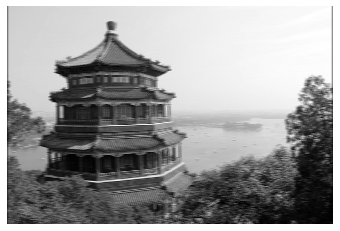

In [25]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

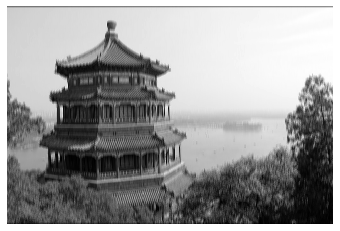

In [27]:
plt.imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

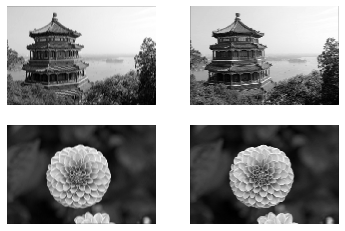

In [29]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [11]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


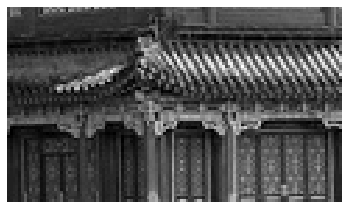

Saving figure china_vertical


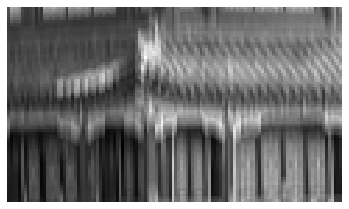

Saving figure china_horizontal


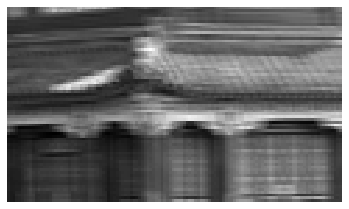

In [12]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

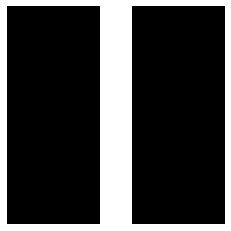

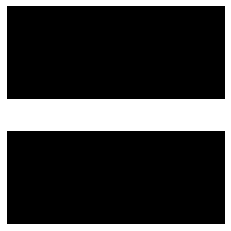

In [13]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

### Convolutional Layer

- in a real CNN, **filters (sets of weights)** are defined as **trainable variables** so that the NN can learn which filters work best

- instead of mannually define filters using **tf.nn.conv2d()**, use **keras.layers.Conv2D()** to define a conv layer

    ```python:
    covn = keras.layers.Conv2D(
        filters=32, 
        kernel_size=3, 
        strides=1, 
        padding='same', 
        activation='relu', 
        )
```

### VALID vs SAME padding

- **SAME**
    - use **zero padding** if needed
    - size of the output is (num of input neurons / stride), rounded up 
    - if strides=1, the output will have the same shape as the input

- **VALID**
    - not using zero padding
    - may ignore some of the rows and columns around the edges, depending on the stride



In [30]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [31]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [32]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [33]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

### Memory Requirement

- Training CNN requires large amount of RAM.

- If out-of-mem error, try 
    - reducing the size of mini-batch, 
    - or, reducing dimensionality using a stride,
    - or, remove a few layers, 
    - or, using 16-bit floats instead of 32-bit, 
    - or, distribute CNN across multiple devices  

## Pooling Layer    

- goal is to **subsample, i.e., shrink** the input image

- reduce computational loads, mem usage

- reduce num of parameters, thereby, limiting the risk of **overfitting**

- a pooling neuron has **no weight**; all it does is to **aggregate** the inputs by **max** or **mean**

- a pooling layer/filter works on every input channel independently, so the num of channels, or depth, of the output is the same as the input

- inserting a max pooling layer every few layers in a CNN can get some level of **translation invariance** at a larger scale. 

- downsides of pooling:
    - losing of information
    - invariance may not be desirable in some applications which favor **equivariance** 

### Max pooling

In [35]:
max_pool = keras.layers.MaxPool2D(pool_size=2) # default padding is "valid", i.e., no padding 

In [36]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


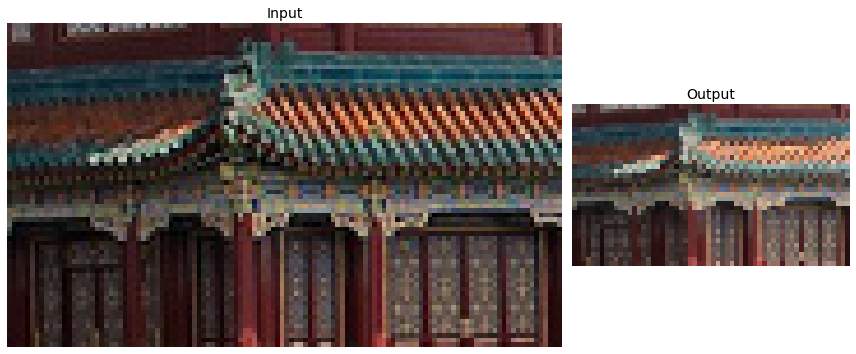

In [41]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

### Depth-wise pooling

In [42]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [43]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [44]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

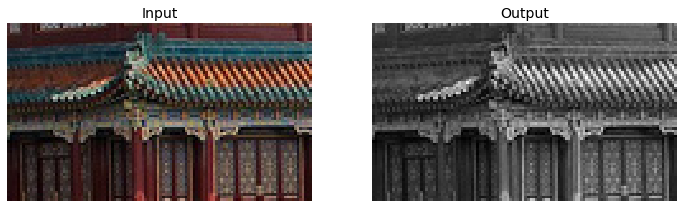

In [45]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### Average pooling

In [46]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [47]:
output_avg = avg_pool(cropped_images)

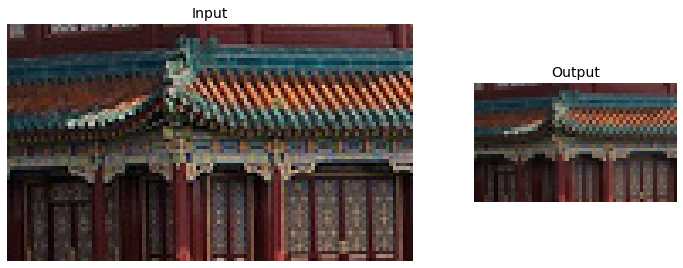

In [48]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Global average pooling

In [49]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [50]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## Tackling Fashion MNIST with a CNN

In [64]:
(X_train_full, y_train_full), (X_test, y_test) \
    = keras.datasets.fashion_mnist.load_data()

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [65]:
# normalization 
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [66]:
from functools import partial

DefaultConv2D = partial(
    keras.layers.Conv2D, 
    kernel_size=3, 
    activation='relu', 
    padding='SAME', 
)

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), 
    keras.layers.MaxPool2D(pool_size=2), 
    DefaultConv2D(filters=128), 
    DefaultConv2D(filters=128), 
    keras.layers.MaxPool2D(pool_size=2),
    DefaultConv2D(filters=256), 
    DefaultConv2D(filters=256), 
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(), 
    keras.layers.Dense(units=128, activation='relu'), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(units=10, activation='softmax'), 
])

In [67]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'], 
)

In [68]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    validation_data=(X_valid, y_valid))

score = model.evaluate(X_test, y_test)
X_new = X_test[:10] 
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 186s 108ms/step - loss: 0.5526 - accuracy: 0.8077 - val_loss: 0.3527 - val_accuracy: 0.8704
Epoch 2/10
1719/1719 [==============================] - 188s 109ms/step - loss: 0.3542 - accuracy: 0.8753 - val_loss: 0.3280 - val_accuracy: 0.8782
Epoch 3/10
1719/1719 [==============================] - 188s 110ms/step - loss: 0.3031 - accuracy: 0.8913 - val_loss: 0.2956 - val_accuracy: 0.8906
Epoch 4/10
1719/1719 [==============================] - 188s 109ms/step - loss: 0.2730 - accuracy: 0.9022 - val_loss: 0.2683 - val_accuracy: 0.9024
Epoch 5/10
1719/1719 [==============================] - 197s 115ms/step - loss: 0.2483 - accuracy: 0.9108 - val_loss: 0.2667 - val_accuracy: 0.9034
Epoch 6/10
1719/1719 [==============================] - 206s 120ms/step - loss: 0.2318 - accuracy: 0.9168 - val_loss: 0.2669 - val_accuracy: 0.9076
Epoch 7/10
1719/1719 [==============================] - 209s 122ms/step - loss: 0.2164 - accuracy: 0.9206 - val_

In [69]:
print(score)

[0.30535250902175903, 0.90420001745224]


In [71]:
print(y_pred)

[[8.0135861e-23 4.4199461e-27 2.9051657e-22 1.0961717e-22 2.4452005e-22
  1.5870992e-12 1.3892550e-19 1.8442165e-08 4.2097514e-17 1.0000000e+00]
 [7.4384903e-09 1.7428659e-23 9.9999678e-01 2.1408764e-16 5.8884791e-07
  3.3539672e-24 2.6065743e-06 3.9096761e-28 1.5071152e-14 6.4250776e-27]
 [1.7445543e-12 1.0000000e+00 9.5718514e-16 3.9987019e-10 1.1274317e-14
  9.5325609e-18 9.4001543e-12 1.0489322e-20 6.1807389e-15 6.7239787e-18]
 [1.4692363e-30 1.0000000e+00 5.3859660e-36 3.1932750e-26 5.1167606e-32
  0.0000000e+00 1.0022519e-25 0.0000000e+00 2.3324104e-35 0.0000000e+00]
 [2.6143748e-02 1.6857193e-12 4.1133594e-03 8.0042475e-05 4.0730359e-03
  2.4475992e-12 9.6558970e-01 6.8038900e-15 7.7264211e-08 1.0193175e-15]
 [1.9937584e-15 1.0000000e+00 3.1370364e-18 1.1175928e-12 1.2300063e-16
  2.6249502e-21 5.7042282e-14 3.4997361e-26 5.7496787e-18 3.5118866e-22]
 [1.9082635e-10 5.4324389e-13 5.4918285e-03 4.1743001e-10 9.9434787e-01
  8.4922981e-17 1.6033863e-04 4.7035041e-19 2.1256549e-12 

In [72]:
y_pred.shape

(10, 10)

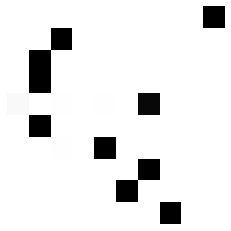

In [78]:
plt.imshow(y_pred,
           cmap='binary')
plt.axis('off')
plt.show()

## ResNet-34